In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [61]:
# build the dataset
block_size = 3
X, Y = [], []

for w in words:
    # create array of block_size with all 0s
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [62]:
X.shape, Y.shape

(torch.Size([228146, 3]), torch.Size([228146]))

In [120]:
def generate_data(words):
    # build the dataset
    block_size = 3
    X, Y = [], []

    for w in words:
        # create array of block_size with all 0s
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print("Size: ", len(words))
    return X, Y

In [123]:
import random
random.seed(42)
random.shuffle(words)

n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)
n1, n2

(25626, 28829)

In [125]:
x_train, y_train = generate_data(words[:n1])
dev_x_train, dev_y_train = generate_data(words[n1:n2])
test_x_train, test_y_train = generate_data(words[n2:])


Size:  25626
Size:  3203
Size:  3204


In [207]:
C = torch.randn((27, 10))
w1 = torch.randn((30, 200)) # 6 inputs and 100 outputs
b1  = torch.randn(200)
w2 = torch.randn(200, 27)
b2 = torch.randn(27)
parameters = [C, w1, b1, w2, b2]

In [208]:
sum(p.nelement() for p in parameters) # number of parameters

11897

In [209]:
for p in parameters:
    p.requires_grad = True

### How to identify a good learning rate? 
We can create an array from range and then run the training pass through each element of that array. Each pass will result in learning rate -> loss mapping.
This mapping can be used to identify learning rate with minimum loss.

In [210]:
# instead of stepping through it lineraly we should do it exponentially
# so that we can process on same learning rate multiple times
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [211]:
losses = []
steps = []

In [212]:
final_loss = 0
l_rates = []
for i in range(200000):
    # mini batch construst
    # instead of looking at all the data in X and Y we can 
    # look at it in random batches to make the whole thing fast
    ix = torch.randint(0, x_train.shape[0], (32,))
    # forward pass
    emb = C[x_train[ix]]
    h  = torch.tanh(emb.view(emb.shape[0], 30) @ w1 + b1)
    logits = h @ w2 + b2
    # counts = logits.exp()
    # probs = counts/counts.sum(1, keepdim=True)
    # loss = -probs[torch.arange(32), Y].log().mean()

    # @notes instead of calculating loss like we did earlier we can use this function from pytorch
    loss = F.cross_entropy(logits, y_train[ix])
    final_loss = loss
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    l_rate = 0.1 if i < 100000 else 0.01
    #update
    for p in parameters:
        p.data += -l_rate * p.grad
    
    # record metrics @commented for learning rate identification
    # l_rates.append(lre[i])
    steps.append(i)
    losses.append(loss.log10().item())

final_loss.item()

1.8446028232574463

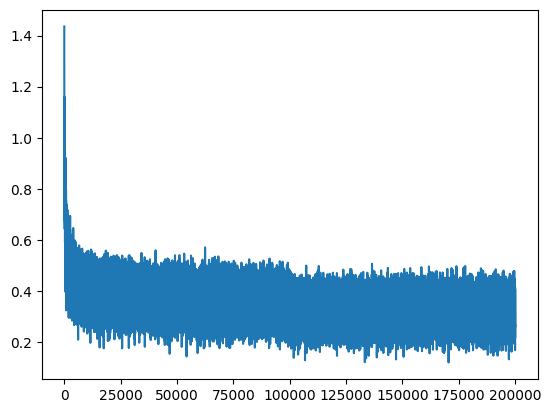

In [213]:
plt.plot(steps, losses)

In [214]:
# loss on all the dev
emb = C[dev_x_train]
h  = torch.tanh(emb.view(emb.shape[0], 30) @ w1 + b1)
logits = h @ w2 + b2
F.cross_entropy(logits, dev_y_train).item()

2.167039394378662

In [215]:
# loss on all the test
emb = C[test_x_train]
h  = torch.tanh(emb.view(emb.shape[0], 30) @ w1 + b1)
logits = h @ w2 + b2
F.cross_entropy(logits, test_y_train).item()

2.1679739952087402

tensor(-0.2508, grad_fn=<SelectBackward0>)

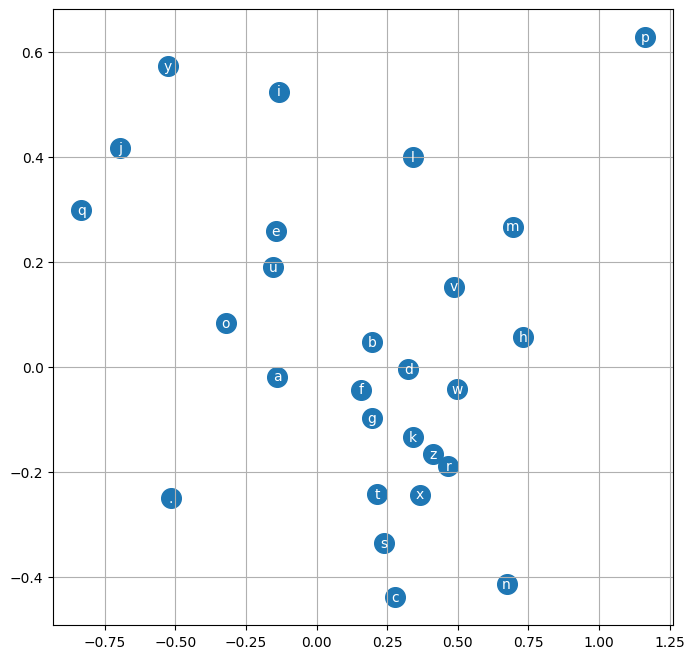

In [172]:
# embedding plot

plt.figure(figsize=(8, 8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')


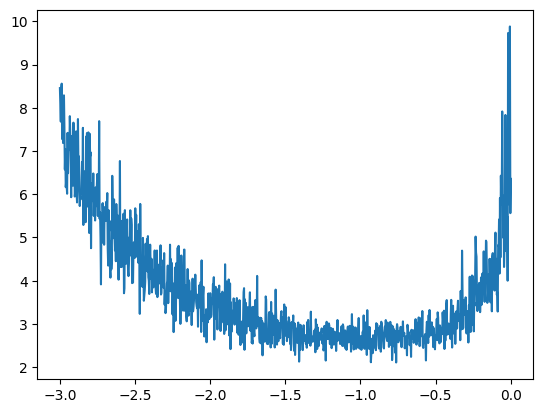

In [99]:
plt.plot(l_rates, losses)

In [217]:
# sampling from model (generating output)
g = torch.Generator().manual_seed(2147483647 + 10)
for i in range(20):
    out = []
    context = [0] * block_size # initialize with all ....
    while True:
        emb = C[torch.tensor([context])] # embedding of input (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ w1 + b1)
        logits = h @ w2 + b2
        probs = F.softmax(logits, dim=1)        
        idx = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        context = context[1:] + [idx]
        out.append(idx)
        if (idx == 0):
            break

    print(''.join(itos[i] for i in out))

carmah.
ambrie.
khi.
milia.
aty.
skanya.
emmahubbiemeryra.
kaeli.
nellara.
chaihvik.
leggyl.
luce.
cadeen.
tis.
lilea.
jadia.
waodha.
dearyx.
kai.
eupius.


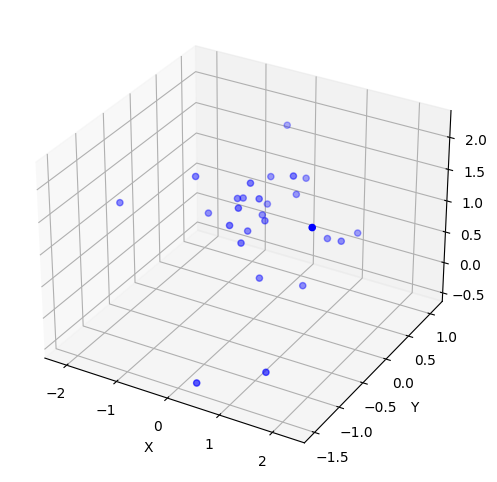

In [220]:
# embedding plot n dimensional

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(C[:,0].data, C[:,1].data, C[:,2].data, c='b', marker='o')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')  

plt.show()

